In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize

from pqcd.utils import rcparams, nsat
plt.rcParams.update(rcparams)

In [2]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values for chiEFT
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

### Random walk

In [3]:
# Choose low and high values for the EOS. These could come from a distribution.
muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

X = 1
muH = 2.6
pQCDX = pqcd.pQCD(X)
nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
epsilonH = pqcd.epsilon_func(muH, nH, pH)

In [ ]:
# We can include the speed of sound constraint at high density; with the 
# (muH, nH) coordinate this effectively determines the EOS behaviour down to
# some transition density nT which we can specify.
nT = 30*nsat

# Beyond nT, the EOS behaviour is n(mu) = beta*mu**3, where
beta = nH/muH**3

# So the point we need to model the EOS up to is (muT, nT), where
muT = (nT/beta)**(1/3)

# We need to get the pressure at muT
mu_T_to_H = np.linspace(muT, muH, 1000)
n_T_to_H = beta*mu_T_to_H**3

Deltap = pqcd.pressure_integral(mu_T_to_H, n_T_to_H, 0)[-1]
pT = pH - Deltap

epsilonT = pqcd.epsilon_func(muT, nT, pT)

In [ ]:
# Or we don't want to fix the speed of sound exactly, but just make it near a
# third. We still specify a transition density nT.
nT = 30*nsat

# A lower value for the speed of sound squared:
cs2_min = 1/3 - 0.1

# An upper value for the speed of sound squared:
cs2_max = 1/3 + 0.1

# Now we perform a random walk from muH to muT, with the constraint that the
# speed of sound squared is within the given range.

# Construct a array of mu values we will evaluate the EOS at. These can be 
# spaced in anyway you like.
mu_array = np.concatenate(([muL], muL + np.logspace(-5, np.log(muH-muL), 1000, base=np.e)))

In [ ]:
muL, muH

In [ ]:
mu_array[0], mu_array[-1]

In [4]:
# Can we smoothly transition between allowing the full causal range for cs2 and
# a small window around 1/3?

cs2_L_min = 0
cs2_L_max = 1

cs2_H_min = 1/3 - 0.1
cs2_H_max = 1/3 + 0.1

n_array = np.linspace(nL, nH, 1000)

# We can define a sigmoid function that transitions between the two ranges
def sigmoid(x, x0, k):
    """
    Compute the sigmoid function with adjustable parameters for transition 
    location and steepness.

    Parameters
    ----------
    x : float or array-like
        The input value(s) to the sigmoid function.

    x0 : float
        The x-value of the sigmoid's midpoint (transition location).

    k : float
        The steepness of the sigmoid curve. Higher values make the transition steeper.

    Returns
    -------
    float or numpy.ndarray
        The computed sigmoid value(s).
    """
    return 1 / (1 + np.exp(-k*(x-x0)))

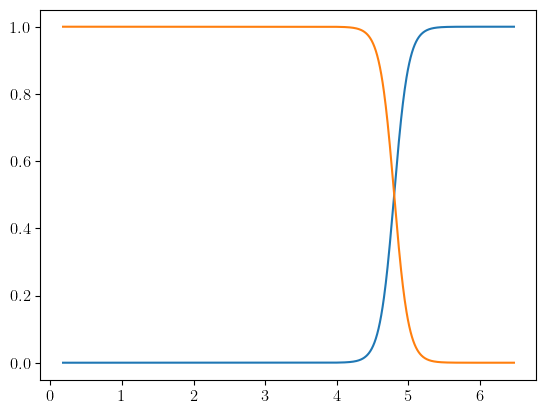

In [5]:
nT = 30*nsat
k = 10

fig, ax = plt.subplots()

ax.plot(n_array, sigmoid(n_array, nT, k), label='Transition function')
_ = ax.plot(n_array, 1-sigmoid(n_array, nT, k), label='Transition function')

In [6]:
cs2_min_array = cs2_L_min + sigmoid(n_array, nT, k)*(cs2_H_min - cs2_L_min)
cs2_max_array = cs2_H_max + (1-sigmoid(n_array, nT, k))*(cs2_L_max - cs2_H_max)

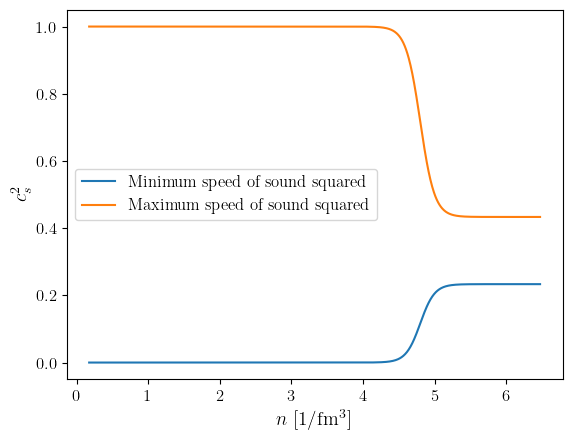

In [7]:
fig, ax = plt.subplots()

ax.plot(n_array, cs2_min_array, label='Minimum speed of sound squared')
ax.plot(n_array, cs2_max_array, label='Maximum speed of sound squared')

ax.set_xlabel(r'$n$ [1/fm$^3$]')
ax.set_ylabel(r'$c_s^2$')
_ = ax.legend()

In [8]:
I_min_array = cumulative_trapezoid(cs2_min_array/n_array, n_array, initial=0)
I_max_array = cumulative_trapezoid(cs2_max_array/n_array, n_array, initial=0)

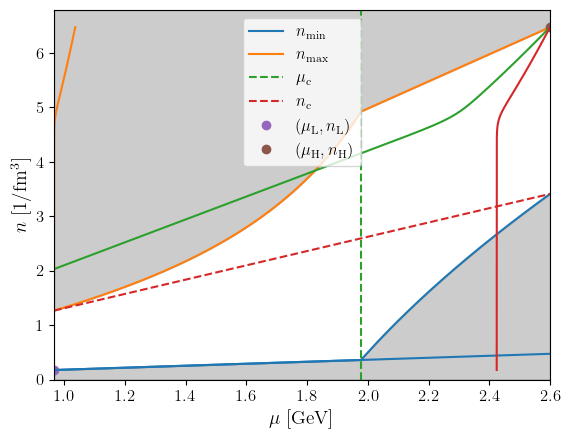

In [9]:
def mu_from_cs2(n, I, mu0, n0):
    return mu0*np.exp(I - I[np.argmin(np.abs(n-n0))])

constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(np.linspace(muL, muH, 1000))

ax.plot(mu_from_cs2(n_array, I_max_array, muL, nL), n_array, c='k')
ax.plot(mu_from_cs2(n_array, I_min_array, muL, nL), n_array, c='k')

ax.plot(mu_from_cs2(n_array, I_max_array, muH, nH), n_array, c='k')
_ = ax.plot(mu_from_cs2(n_array, I_min_array, muH, nH), n_array, c='k')

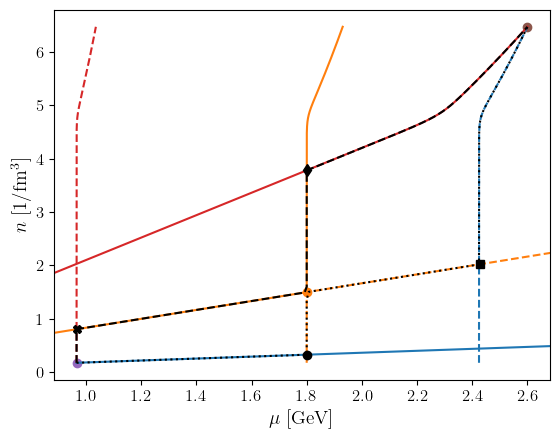

In [10]:
fig, ax = plt.subplots()

ax.plot(muL, nL, 'o', c='C4')
ax.plot(muH, nH, 'o', c='C5')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

mu_max_L = mu_from_cs2(n_array, I_max_array, muL, nL)
mu_max_H = mu_from_cs2(n_array, I_min_array, muH, nH)

ax.plot(
    mu_max_L, 
    n_array,
    c='C0'
)

ax.plot(
    mu_max_H,
    n_array,
    c='C0',
    ls='--'
)

mu_min_L = mu_from_cs2(n_array, I_min_array, muL, nL)
mu_min_H = mu_from_cs2(n_array, I_max_array, muH, nH)

ax.plot(
    mu_min_H,
    n_array,
    c='C3'
)

ax.plot(
    mu_min_L,
    n_array,
    c='C3',
    ls='--'
)

mu0, n0 = 1.8, 1.5
ax.plot(mu0, n0, 'o', c='C1')

mu_0_I_max = mu_from_cs2(n_array, I_max_array, mu0, n0)
mu_0_I_min = mu_from_cs2(n_array, I_min_array, mu0, n0)

mu_0_min = np.concatenate((mu_0_I_max[mu_0_I_max < mu0], mu_0_I_min[mu_0_I_min > mu0]))
n_0_min = np.concatenate((n_array[mu_0_I_max < mu0], n_array[mu_0_I_min > mu0]))

ax.plot(mu_0_min, n_0_min, c='C1')

mu_0_max = np.concatenate((mu_0_I_min[mu_0_I_min < mu0], mu_0_I_max[mu_0_I_max > mu0]))
n_0_max = np.concatenate((n_array[mu_0_I_min < mu0], n_array[mu_0_I_max > mu0]))

ax.plot(mu_0_max, n_0_max, c='C1', ls='--')

min_p_cross_index_1 = np.argmin(np.abs(
    mu_0_I_min - mu_max_L
))
ax.plot(
    mu_0_I_min[min_p_cross_index_1],
    n_array[min_p_cross_index_1],
    'o', c='k'
)

min_p_cross_index_2 = np.argmin(np.abs(
    mu_0_I_max - mu_max_H
))
ax.plot(
    mu_0_I_max[min_p_cross_index_2],
    n_array[min_p_cross_index_2],
    's', c='k'
)

max_p_cross_index_1 = np.argmin(np.abs(
    mu_0_I_min - mu_min_H
))
ax.plot(
    mu_0_I_min[max_p_cross_index_1],
    n_array[max_p_cross_index_1],
    'd', c='k'
)

max_p_cross_index_2 = np.argmin(np.abs(
    mu_0_I_max - mu_min_L
))
ax.plot(
    mu_0_I_max[max_p_cross_index_2],
    n_array[max_p_cross_index_2],
    'X', c='k'
)

mask = (n_0_max > n_array[min_p_cross_index_1]) & (mu_0_max < mu_0_I_max[min_p_cross_index_2])

mu_min_p = np.concatenate((
    mu_max_L[mu_max_L < mu0],
    mu_0_max[mask],
    mu_max_H[min_p_cross_index_2:]
))

n_min_p = np.concatenate((
    n_array[mu_max_L < mu0],
    n_0_max[mask],
    n_array[min_p_cross_index_2:]
))

ax.plot(mu_min_p, n_min_p, c='k', ls=':')

mask = (mu_0_min > mu_0_I_max[max_p_cross_index_2]) & (n_0_min < n_array[max_p_cross_index_1])

mu_max_p = np.concatenate((
    mu_min_L[:max_p_cross_index_2],
    mu_0_min[mask],
    mu_min_H[max_p_cross_index_1:]
))

n_max_p = np.concatenate((
    n_array[:max_p_cross_index_2],
    n_0_min[mask],
    n_array[max_p_cross_index_1:]
))

ax.plot(mu_max_p, n_max_p, c='k', ls='--')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\mu$ [GeV]')
_ = ax.set_ylabel(r'$n$ [1/fm$^3$]')

In [11]:
Deltap = pH - pL

pL, pH, Deltap

(0.002163, 3.8232745461649347, 3.8211115461649348)

In [12]:
min_Deltap = pqcd.pressure_integral(
    mu_min_p, n_min_p, 0
)[-1]
min_Deltap

2.2903353896941248

In [13]:
max_Deltap = pqcd.pressure_integral(
    mu_max_p, n_max_p, 0
)[-1]
max_Deltap

4.8155108486255935

In [30]:
def fun_max(n0, mu0):
        
        mu_0_I_max = mu_from_cs2(n_array, I_max_array, mu0, n0)
        mu_0_I_min = mu_from_cs2(n_array, I_min_array, mu0, n0)

        mu_0_max = np.concatenate((mu_0_I_min[mu_0_I_min < mu0], mu_0_I_max[mu_0_I_max > mu0]))
        n_0_max = np.concatenate((n_array[mu_0_I_min < mu0], n_array[mu_0_I_max > mu0]))

        min_p_cross_index_1 = np.argmin(np.abs(
            mu_0_I_min - mu_max_L
        ))

        min_p_cross_index_2 = np.argmin(np.abs(
            mu_0_I_max - mu_max_H
        ))

        mask = (n_0_max > n_array[min_p_cross_index_1]) & (mu_0_max < mu_0_I_max[min_p_cross_index_2])

        mu_min_p = np.concatenate((
            mu_max_L[mu_max_L < mu0],
            mu_0_max[mask],
            mu_max_H[min_p_cross_index_2:]
        ))

        n_min_p = np.concatenate((
            n_array[mu_max_L < mu0],
            n_0_max[mask],
            n_array[min_p_cross_index_2:]
        ))

        Deltap_min = pqcd.pressure_integral(
            mu_min_p, n_min_p, 0
        )[-1]

        return abs(Deltap_min - Deltap)

In [31]:
def fun_min(n0, mu0):

    mu_0_I_max = mu_from_cs2(n_array, I_max_array, mu0, n0)
    mu_0_I_min = mu_from_cs2(n_array, I_min_array, mu0, n0)

    mu_0_min = np.concatenate((mu_0_I_max[mu_0_I_max < mu0], mu_0_I_min[mu_0_I_min > mu0]))
    n_0_min = np.concatenate((n_array[mu_0_I_max < mu0], n_array[mu_0_I_min > mu0]))

    max_p_cross_index_1 = np.argmin(np.abs(
        mu_0_I_min - mu_min_H
    ))

    max_p_cross_index_2 = np.argmin(np.abs(
        mu_0_I_max - mu_min_L
    ))

    mask = (mu_0_min > mu_0_I_max[max_p_cross_index_2]) & (n_0_min < n_array[max_p_cross_index_1])

    mu_max_p = np.concatenate((
        mu_min_L[:max_p_cross_index_2],
        mu_0_min[mask],
        mu_min_H[max_p_cross_index_1:]
    ))

    n_max_p = np.concatenate((
        n_array[:max_p_cross_index_2],
        n_0_min[mask],
        n_array[max_p_cross_index_1:]
    ))

    Deltap_max = pqcd.pressure_integral(
        mu_max_p, n_max_p, 0
    )[-1]

    return abs(Deltap_max - Deltap)

In [32]:
mu_max_integral = []
n_max_integral = []

mu_min_integral = []
n_min_integral = []

n0_min_guess = nL
n0_max_guess = nL

for mu0 in mu_array:

    n_lower = max((
        n_array[np.argmin(abs(mu_max_L-mu0))],
        n_array[np.argmin(abs(mu_max_H-mu0))]
    ))

    n_upper = min((
        n_array[np.argmin(abs(mu_min_L-mu0))],
        n_array[np.argmin(abs(mu_min_H-mu0))]
    ))

    res_min = minimize(
        fun_min, 
        n0_min_guess, 
        args=(mu0),
        method='Nelder-Mead',
        bounds=[(n_lower, n_upper)]
        )

    if res_min.success:
        n_max_integral.append(res_min.x[0])
        mu_max_integral.append(mu0)
        n0_min_guess = res_min.x[0]

    res_max = minimize(
        fun_max, 
        n0_max_guess, 
        args=(mu0),
        method='Nelder-Mead',
        bounds=[(n_lower, n_upper)]
        )
    
    if res_max.success:
        n_min_integral.append(res_max.x[0])
        mu_min_integral.append(mu0)
        n0_max_guess = res_max.x[0]

/var/folders/x6/wnwfrzv1471c46w4cryby1pw0000gn/T/ipykernel_5738/2671326811.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  res_min = minimize(
/var/folders/x6/wnwfrzv1471c46w4cryby1pw0000gn/T/ipykernel_5738/2671326811.py:35: OptimizeWarning: Initial guess is not within the specified bounds
  res_max = minimize(


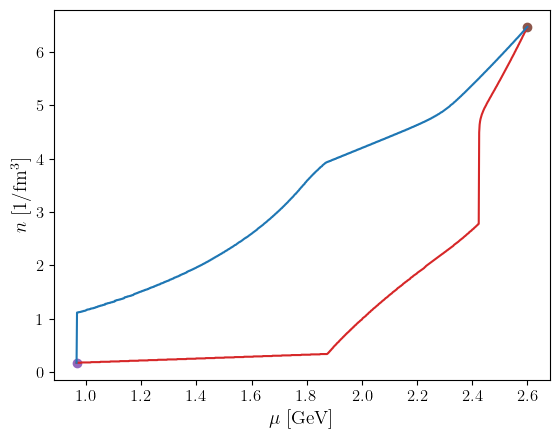

In [36]:
fig, ax = plt.subplots()

ax.plot(muL, nL, 'o', c='C4')
ax.plot(muH, nH, 'o', c='C5')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# ax.plot(
#     mu_max_L, 
#     n_array,
#     c='C0'
# )

# ax.plot(
#     mu_max_H,
#     n_array,
#     c='C0',
# )

# ax.plot(
#     mu_min_H,
#     n_array,
#     c='C3'
# )

# ax.plot(
#     mu_min_L,
#     n_array,
#     c='C3',
# )

ax.plot(mu_max_integral, n_max_integral, c='C3')
ax.plot(mu_min_integral, n_min_integral, c='C0')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\mu$ [GeV]')
_ = ax.set_ylabel(r'$n$ [1/fm$^3$]')

In [ ]:
# Starting from (muH, nH), we generate the next point in the EOS at random 
# whilst satisfying the speed of sound constraints

rng = np.random.default_rng()

# Figure for debugging

constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(mu_array)
fig.set_dpi(180)

ax.axhline(nT, color='C7', linestyle='--', label=r'$n_\mathrm{T}$')
ax.legend()

def n_at_fixed_cs2(mu, cs2, mu0, n0):
    return n0*(mu/mu0)**(1/cs2)

nmin_array = n_at_fixed_cs2(mu_array, cs2_min, muH, nH)
ax.plot(mu_array[nmin_array>nT], nmin_array[nmin_array>nT], color='C0', linestyle='--')

nmax_array = n_at_fixed_cs2(mu_array, cs2_max, muH, nH)
ax.plot(mu_array[nmax_array>nT], nmax_array[nmax_array>nT], color='C1', linestyle='--')

# Initialise n and p arrays

n_T_to_H = [nH]

current_n = nH

for i in range(len(mu_array)):

    current_mu = mu_array[::-1][i]
    next_mu = mu_array[::-1][i+1]

    next_n_lower = n_at_fixed_cs2(next_mu, cs2_min, current_mu, current_n)
    next_n_upper = n_at_fixed_cs2(next_mu, cs2_max, current_mu, current_n)

    next_n = rng.uniform(next_n_lower, next_n_upper)

    if next_n > nT:
        n_T_to_H.append(next_n)
        current_n = next_n
    else:
        break

n_T_to_H = np.array(n_T_to_H)[::-1]
mu_T_to_H = mu_array[-len(n_T_to_H):]

ax.plot(mu_T_to_H, n_T_to_H, color='k', alpha=0.1)

In [ ]:
cs2_T_to_H = 1/(mu_T_to_H/n_T_to_H*np.gradient(n_T_to_H, mu_T_to_H))

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_T_to_H, cs2_T_to_H)

ax.axhline(1/3, color='C7', linestyle='--')
ax.axhline(cs2_min, color='C0', linestyle='--')
ax.axhline(cs2_max, color='C1', linestyle='--')

ax.axvline(nT, color='C7', linestyle='--')
ax.axvline(nH, color='C7', linestyle='--')

In [ ]:
# Construct a array of mu values we will evaluate the EOS at. These can be 
# spaced in anyway you like.
mu_L_to_T = np.concatenate(([muL], muL + np.logspace(-5, np.log(muT-muL), 1000, base=np.e)))[:-1]

In [ ]:
mu_L_to_T[0], mu_L_to_T[-1], mu_T_to_H[0], mu_T_to_H[-1]

In [ ]:
mu_array = np.concatenate((mu_L_to_T, mu_T_to_H))

### Single figure

In [ ]:
# Starting from (muL, nL), we generate the next point in the EOS at random 
# whilst satisfying the integral constraints

rng = np.random.default_rng(460)

# Figure for debugging

constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(mu_array)
fig.set_dpi(180)

ax.plot(muT, nT, 'o', color='C7')
ax.plot(mu_T_to_H, n_T_to_H, color='C7', zorder=0.5)

# Initialise n and p arrays

n_L_to_T = [nL]
p_L_to_T = [pL]

current_n = nL
current_p = pL

# There are situations where the EOS behaviour becomes determined. We can 
# break the loop over mu values when this happens.
determined = False

for i in range(len(mu_L_to_T)-1):

    current_mu = mu_L_to_T[i]
    next_mu = mu_L_to_T[i+1]

    constraints = pqcd.constraints(
        muL=current_mu, nL=current_n, pL=current_p, muH=muT, nH=nT, pH=pT
        )

    # From causality and the integral constraints, we can find the minimum and
    # maximum values for n at the next mu value
    try:
        next_n_lower = constraints.nmin(next_mu)
        next_n_upper = constraints.nmax(next_mu)
    except ValueError:
        print('ValueError')
        ax.plot(mu_L_to_T[:len(n_L_to_T)], n_L_to_T, color='k')

    # We may have a situation where the window for n has shrunk so much that 
    # n_lower is greater than n_upper. In this case, we have to enforce the 
    # causal limit and the EOS becomes determined.
    if next_n_lower > next_n_upper:
        print('n_lower > n_upper')
        determined = True
        gradient = current_n/current_mu
        break

    else:

        # We can limit the range we draw the next n from to enforce smoothness.
        # limit is a nonzero number between 0 and 1.
        limit = 0.01
        next_n = rng.uniform(
            next_n_lower, next_n_lower+limit*(next_n_upper - next_n_lower)
            )
        n_L_to_T.append(next_n)

        # Calculate the corresponding p value
        next_p = current_p + 0.5*(current_n + next_n)*(next_mu - current_mu)
        p_L_to_T.append(next_p)

        # If our proposed point is sufficiently close to the nmin curve due to
        # the integral constraints (i.e., the part of the nmin curve for mu > 
        # muc), then we have a phase transition to follow the nmax line.

        tolerance = 1e-3
        if (next_mu > constraints.muc) and (np.abs(next_n - next_n_lower) < tolerance):
            print('n - n_lower < tolerance')
            determined = True
            gradient = nT/muT
            break

        # We may also have a situation where we hit the nmax curve for mu < 
        # muc. In this situation we follow the causal line all the way to muT. 
        if next_mu < constraints.muc and np.abs(next_n - next_n_upper) < tolerance:
            print('n - n_upper < tolerance')
            determined = True
            gradient = next_n/next_mu
            break

    current_n = next_n
    current_p = next_p

if determined:
    remaining_mu = mu_L_to_T[len(n_L_to_T):]
    n_L_to_T = np.concatenate((n_L_to_T, remaining_mu*gradient))
    p_L_to_T = np.concatenate((p_L_to_T, pqcd.pressure_integral(remaining_mu, remaining_mu*gradient, p_L_to_T[-1])))

_ = ax.plot(mu_L_to_T, n_L_to_T, color='k')

In [ ]:
n_array = np.concatenate((n_L_to_T, n_T_to_H))
p_array = np.concatenate((p_L_to_T, pqcd.pressure_integral(mu_T_to_H, n_T_to_H, pT)))
epsilon_array = pqcd.epsilon_func(mu_array, n_array, p_array)

In [ ]:
fig, ax = plt.subplots()
# ax.set_xscale('log')
# ax.set_yscale('log')

ax.plot(
    epsilon_array, 
    p_array, 
    # marker='.', 
    color='k'
    )

ax.plot(epsilonL, pL, 'o', color='C0')
ax.plot(epsilonH, pH, 'o', color='C1')

ax.axvline(epsilonT, ls='--')
ax.axhline(pT, ls='--')

ax.set_xlim(epsilonT - 1, epsilonT + 1)
ax.set_ylim(pT - 1, pT + 1)

ax.set_xlabel(r'$\epsilon$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'$p$ [GeV/fm$^3$]')

In [ ]:
len(p_array)

In [ ]:
len(set(p_array))

### Figure series

In [ ]:
# Starting from (muL, nL), we generate the next point in the EOS at random 
# whilst satisfying the integral constraints

rng = np.random.default_rng(460)

# Initialise n and p arrays

n_L_to_T = [nL]
p_L_to_T = [pL]

current_n = nL
current_p = pL

# There are situations where the EOS behaviour becomes determined. We can 
# break the loop over mu values when this happens.
determined = False

for i in range(len(mu_L_to_T)-1):

# Figure for debugging

    constraints = pqcd.constraints(
        muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
        )

    fig, ax = constraints.plot_mu_n(mu_array)

    ax.plot(muT, nT, 'o', color='C7')
    ax.plot(mu_T_to_H, n_T_to_H, color='C7', zorder=0.5)

    current_mu = mu_L_to_T[i]
    next_mu = mu_L_to_T[i+1]

    constraints = pqcd.constraints(
        muL=current_mu, nL=current_n, pL=current_p, muH=muT, nH=nT, pH=pT
        )

    # From causality and the integral constraints, we can find the minimum and
    # maximum values for n at the next mu value
    try:
        next_n_lower = constraints.nmin(next_mu)
        next_n_upper = constraints.nmax(next_mu)
    except ValueError:
        print('ValueError')

    # We may have a situation where the window for n has shrunk so much that 
    # n_lower is greater than n_upper. In this case, we have to enforce the 
    # causal limit and the EOS becomes determined.
    if next_n_lower > next_n_upper:
        print('n_lower > n_upper')
        determined = True
        gradient = current_n/current_mu
        break

    else:

        # Plot upper and lower bounds on n
        ax.plot(next_mu, next_n_lower, '^', color='C3', alpha=0.5, markeredgewidth=0)
        ax.plot(next_mu, next_n_upper, 'v', color='C3', alpha=0.5, markeredgewidth=0)

        # And the corresponding allowed region
        temp_mu = np.linspace(next_mu, muT, 1000)
        ax.plot(temp_mu, constraints.nmin(temp_mu), color='k', alpha=0.5)
        ax.plot(temp_mu, constraints.nmax(temp_mu), color='k', alpha=0.5)

        # We can limit the range we draw the next n from to enforce smoothness.
        # limit is a nonzero number between 0 and 1.
        limit = 0.01
        next_n = rng.uniform(
            next_n_lower, next_n_lower+limit*(next_n_upper - next_n_lower)
            )
        n_L_to_T.append(next_n)

        ax.plot(next_mu, next_n, '.', color='k')

        # Calculate the corresponding p value
        next_p = current_p + 0.5*(current_n + next_n)*(next_mu - current_mu)
        p_L_to_T.append(next_p)

        # If our proposed point is sufficiently close to the nmin curve due to
        # the integral constraints (i.e., the part of the nmin curve for mu > 
        # muc), then we have a phase transition to follow the nmax line.

        tolerance = 1e-3
        if (next_mu > constraints.muc) and (np.abs(next_n - next_n_lower) < tolerance):
            print('n - n_lower < tolerance')
            determined = True
            gradient = nT/muT
            break

        # We may also have a situation where we hit the nmax curve for mu < 
        # muc. In this situation we follow the causal line all the way to muT. 
        if next_mu < constraints.muc and np.abs(next_n - next_n_upper) < tolerance:
            print('n - n_upper < tolerance')
            determined = True
            gradient = next_n/next_mu
            break

    current_n = next_n
    current_p = next_p

    fig.savefig(f'eos_test_3/{i}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

if determined:
    remaining_mu = mu_L_to_T[len(n_L_to_T):]
    n_L_to_T = np.concatenate((n_L_to_T, remaining_mu*gradient))
    p_L_to_T = np.concatenate((p_L_to_T, pqcd.pressure_integral(remaining_mu, remaining_mu*gradient, p_L_to_T[-1])))

## Repeat

In [ ]:
# Starting from (muL, nL), we generate the next point in the EOS at random 
# whilst satisfying the integral constraints

rng = np.random.default_rng()

# Figure for debugging

constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(mu_array)
fig.set_dpi(180)

ax.plot(muT, nT, 'o', color='C7')
ax.plot(mu_T_to_H, n_T_to_H, color='C7', zorder=0.5)

constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muT, nH=nT, pH=pT
    )

ax.plot(mu_L_to_T, constraints.nmin(mu_L_to_T), color='C3')
ax.plot(mu_L_to_T, constraints.nmax(mu_L_to_T), color='C3')

Nrepeats = 1000
for n in range(Nrepeats):

    alpha = 0.5

    plot = False
    limit_switch = True

    limit = np.exp(rng.uniform(-10, -2)) # 0.01
    # print(f'limit = {limit}')

    # limit_switch_prob = 0.5
    # if rng.uniform() < limit_switch_prob:
    #     limit_switch = True
    #     switch_index = rng.integers(0, len(mu_L_to_T))
    #     new_limit = np.exp(rng.uniform(-5, 0))

    mu_switch = rng.uniform(muL, muT)
    switch_index = np.argmin(np.abs(mu_L_to_T - mu_switch))
    new_limit = np.exp(rng.uniform(-5, 0))

    # Initialise n and p arrays

    n_L_to_T = [nL]
    p_L_to_T = [pL]

    current_n = nL
    current_p = pL

    # There are situations where the EOS behaviour becomes determined. We can 
    # break the loop over mu values when this happens.
    determined = False

    for i in range(len(mu_L_to_T)-1):

        current_mu = mu_L_to_T[i]
        next_mu = mu_L_to_T[i+1]

        constraints = pqcd.constraints(
            muL=current_mu, nL=current_n, pL=current_p, muH=muT, nH=nT, pH=pT
            )

        # From causality and the integral constraints, we can find the minimum and
        # maximum values for n at the next mu value
        try:
            next_n_lower = constraints.nmin(next_mu)
            next_n_upper = constraints.nmax(next_mu)
        except ValueError:
            print('ValueError')
            alpha = 0
            # ax.plot(mu_L_to_T[:len(n_L_to_T)], n_L_to_T, color='k')

        # We may have a situation where the window for n has shrunk so much that 
        # n_lower is greater than n_upper. In this case, we have to enforce the 
        # causal limit and the EOS becomes determined.
        if next_n_lower > next_n_upper:
            print('n_lower > n_upper')
            determined = True
            gradient = current_n/current_mu
            if current_n < 1:
                plot = True
            break

        else:

            # We can limit the range we draw the next n from to enforce smoothness.
            # limit is a nonzero number between 0 and 1.
            if limit_switch:
                if i == switch_index:
                    limit = new_limit

            next_n = rng.uniform(
                next_n_lower, next_n_lower+limit*(next_n_upper - next_n_lower)
                )
            n_L_to_T.append(next_n)

            # if (1.6 < next_mu < 1.8) and (0.5 < next_n < 0.75):
            #     print(f'EOS: {n}, limit: {limit}')

            # Calculate the corresponding p value
            next_p = current_p + 0.5*(current_n + next_n)*(next_mu - current_mu)
            p_L_to_T.append(next_p)

            # If our proposed point is sufficiently close to the nmin curve due to
            # the integral constraints (i.e., the part of the nmin curve for mu > 
            # muc), then we have a phase transition to follow the nmax line.

            tolerance = 1e-3
            if (next_mu > constraints.muc) and (np.abs(next_n - next_n_lower) < tolerance):
                print('n - n_lower < tolerance')
                determined = True
                gradient = nT/muT
                break

            # We may also have a situation where we hit the nmax curve for mu < 
            # muc. In this situation we follow the causal line all the way to muT. 
            if next_mu < constraints.muc and np.abs(next_n - next_n_upper) < tolerance:
                print('n - n_upper < tolerance')
                determined = True
                gradient = next_n/next_mu
                break

        current_n = next_n
        current_p = next_p

    if determined:
        remaining_mu = mu_L_to_T[len(n_L_to_T):]
        n_L_to_T = np.concatenate((n_L_to_T, remaining_mu*gradient))
        try:
            p_L_to_T = np.concatenate((p_L_to_T, pqcd.pressure_integral(remaining_mu, remaining_mu*gradient, p_L_to_T[-1])))
        except ValueError:
            alpha = 0
            pass
            # print('ValueError: pressure_integral')

    if plot:
        _ = ax.plot(mu_L_to_T, n_L_to_T, color='k', alpha=alpha)

In [ ]:
fig, ax = plt.subplots()

# ax.hist(np.exp(rng.uniform(-10, 0, 1000)), bins=50, density=True)
# ax.hist(np.exp(rng.uniform(-5, 0, 1000)), bins=50, density=True)

# lognormal_samples = rng.lognormal(0, 2, 10000)
# lognormal_samples = lognormal_samples[lognormal_samples < 1]
# ax.hist(lognormal_samples, bins=50, density=True)

exponential_samples = rng.exponential(0.1, 10000)
# exponential_samples = exponential_samples[exponential_samples < 1]
ax.hist(exponential_samples, bins=50, density=True)


ax.set_xlabel('limit')

In [ ]:
def draw_eos(muL, nL, pL, muH, nH, pH, nT):

    # Beyond nT, the EOS behaviour is n(mu) = beta*mu**3, where
    beta = nH/muH**3

    # So the point we need to model the EOS up to is (muT, nT), where
    muT = (nT/beta)**(1/3)

    # We need to get the pressure at muT
    mu_T_to_H = np.linspace(muT, muH, 500)
    n_T_to_H = beta*mu_T_to_H**3

    Deltap = pqcd.pressure_integral(mu_T_to_H, n_T_to_H, 0)[-1]
    pT = pH - Deltap

    # Construct a array of mu values we will evaluate the EOS at. These can be 
    # spaced in anyway you like.
    mu_L_to_T = np.concatenate(([muL], muL + np.logspace(-5, np.log(muT-muL), 500, base=np.e)))[:-1]

    # The complete mu_array from muL to muH
    mu_array = np.concatenate((mu_L_to_T, mu_T_to_H))

    # Starting from (muL, nL), we generate the next point in the EOS at random 
    # whilst satisfying the integral constraints

    # Initialise n and p arrays

    n_L_to_T = [nL]
    p_L_to_T = [pL]

    current_n = nL
    current_p = pL

    # There are situations where the EOS behaviour becomes determined. We can 
    # break the loop over mu values when this happens.
    determined = False

    for i in range(len(mu_L_to_T)-1):

        current_mu = mu_L_to_T[i]
        next_mu = mu_L_to_T[i+1]

        constraints = pqcd.constraints(
            muL=current_mu, nL=current_n, pL=current_p, muH=muT, nH=nT, pH=pT
            )

        # From causality and the integral constraints, we can find the minimum and
        # maximum values for n at the next mu value
        next_n_lower = constraints.nmin(next_mu)
        next_n_upper = constraints.nmax(next_mu)

        # We may have a situation where the window for n has shrunk so much that 
        # n_lower is greater than n_upper. In this case, we have to enforce the 
        # causal limit and the EOS becomes determined.
        if next_n_lower > next_n_upper:
            # print('n_lower > n_upper')
            determined = True
            gradient = current_n/current_mu
            break

        else:

            # We can limit the range we draw the next n from to enforce smoothness.
            # limit is a nonzero number between 0 and 1.
            limit = rng.uniform(0, 1) # 0.01
            print(limit)
            next_n = rng.uniform(
                next_n_lower, next_n_lower+limit*(next_n_upper - next_n_lower)
                )
            n_L_to_T.append(next_n)

            # Calculate the corresponding p value
            next_p = current_p + 0.5*(current_n + next_n)*(next_mu - current_mu)
            p_L_to_T.append(next_p)

            # If our proposed point is sufficiently close to the nmin curve due to
            # the integral constraints (i.e., the part of the nmin curve for mu > 
            # muc), then we have a phase transition to follow the nmax line.

            tolerance = 1e-4
            if next_mu > constraints.muc and np.abs(next_n - next_n_lower) < tolerance:
                # print('n - n_lower < tolerance')
                determined = True
                gradient = nT/muT
                break

            # We may also have a situation where we hit the nmax curve for mu < 
            # muc. In this situation we follow the causal line all the way to muT. 
            if next_mu < constraints.muc and np.abs(next_n - next_n_upper) < tolerance:
                # print('n - n_upper < tolerance')
                determined = True
                gradient = next_n/next_mu
                break

        current_n = next_n
        current_p = next_p

    if determined:
        remaining_mu = mu_L_to_T[len(n_L_to_T):]
        n_L_to_T = np.concatenate((n_L_to_T, remaining_mu*gradient))
        p_L_to_T = np.concatenate((p_L_to_T, pqcd.pressure_integral(remaining_mu, remaining_mu*gradient, p_L_to_T[-1])))

    n_array = np.concatenate((n_L_to_T, n_T_to_H))
    p_array = np.concatenate((p_L_to_T, pqcd.pressure_integral(mu_T_to_H, n_T_to_H, pT)))
    epsilon_array = pqcd.epsilon_func(mu_array, n_array, p_array)

    return mu_array, n_array, p_array, epsilon_array

In [ ]:
rng = np.random.default_rng()

constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(mu_array)
fig.set_dpi(180)

ax.plot(muT, nT, 'o', color='C7')
ax.plot(mu_T_to_H, n_T_to_H, color='C7', zorder=1)

N = 5000
success_count = 0
for n in range(N):
    try:
        mu_array, n_array, p_array, epsilon_array = draw_eos(muL, nL, pL, muH, nH, pH, nT)
        ax.plot(mu_array, n_array, color='k', alpha=1, zorder=0.01)
        success_count += 1
    except ValueError:
        continue

In [ ]:
pL, pT, pH

In [ ]:
p_array[0], p_array[-1]

In [ ]:
fig, ax = plt.subplots()
# ax.set_xscale('log')
# ax.set_yscale('log')

ax.plot(epsilon_array, p_array, marker='o', color='C0')

ax.plot(epsilonL, pL, 'o', color='C0')
ax.plot(epsilonH, pH, 'o', color='C1')

ax.axvline(pqcd.epsilon_func(muT, nT, pT))
ax.axhline(pT)

ax.set_xlabel(r'$\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')

In [ ]:
# Construct a array of mu values we will evaluate the EOS at. These can be 
# spaced in anyway you like.
mu_array = np.concatenate(([muL], muL + np.logspace(-5, np.log(muT-muL), 500, base=np.e)))[:-1]

# Starting from (muL, nL), we generate the next point in the EOS at random 
# whilst satisfying the integral constraints.

constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
    )

fig, ax = constraints.plot_mu_n(np.concatenate((mu_array, mu_T_to_H)))
fig.set_dpi(180)

alt_constraints = pqcd.constraints(
    muL=muL, nL=nL, pL=pL, muH=muT, nH=nT, pH=pT
    )
ax.plot(mu_array, alt_constraints.nmin(mu_array), c='k', alpha=0.5)
ax.plot(mu_array, alt_constraints.nmax(mu_array), c='k', alpha=0.5)

ax.plot(muT, nT, 'o', color='C7')
ax.plot(mu_T_to_H, n_T_to_H, color='C7', zorder=0.5)

rng = np.random.default_rng(84)

N = 1

for _ in range(N):

    n_array = [nL]
    p_array = [pL]

    current_n = nL
    current_p = pL

    causal_limit = False
    phase_transition = False

    for i in range(len(mu_array)-1):

        current_mu = mu_array[i]
        next_mu = mu_array[i+1]

        if phase_transition:
            causal_limit = True
            next_n = phase_transition_destination
            n_array.append(next_n)
            next_p = current_p
            p_array.append(next_p)
            phase_transition = False

        elif not causal_limit:

            constraints = pqcd.constraints(
                muL=current_mu, nL=current_n, pL=current_p, muH=muT, nH=nT, pH=pT
                )

            try:
                next_n_lower = constraints.nmin(next_mu)
                next_n_upper = constraints.nmax(next_mu)

            except ValueError:
                print(f'Current mu: {current_mu}, current n: {current_n}, current p: {current_p}')
                ax.plot(mu_array[:len(n_array)], n_array, color='k', alpha=0.5)

            if next_n_lower < next_n_upper:

                next_n = rng.uniform(next_n_lower, next_n_lower+0.01*(next_n_upper - next_n_lower))

                # Check if the next_n proposal is "close" to nmin, which would
                # cause a phase transition
                tolerance = 5e-5
                if next_mu > constraints.muc and np.abs(next_n - next_n_lower) < tolerance:
                    phase_transition = True
                    phase_transition_destination = next_n_upper
                    causal_limit = True

                n_array.append(next_n)
            
            else:

                causal_limit = True

                # We have restricted the EOS to having to follow the causal limit
                next_n = (current_n/current_mu)*next_mu
                n_array.append(next_n)

        else:
                
            next_n = (current_n/current_mu)*next_mu
            n_array.append(next_n)

        next_p = current_p + 0.5*(current_n + next_n)*(next_mu - current_mu)
        p_array.append(next_p)

        current_n = next_n
        current_p = next_p

    ax.plot(mu_array, n_array, color='k', alpha=0.5)

ax.set_xlim(2.2, 2.4)
ax.set_ylim(4, 5)

In [ ]:
n_array = np.hstack((n_array, n_T_to_H))
mu_array = np.hstack((mu_array, mu_T_to_H))
p_array = np.hstack((p_array, pqcd.pressure_integral(mu_T_to_H, n_T_to_H, pT)))
epsilon_array = pqcd.epsilon_func(mu_array, n_array, p_array)

In [ ]:
len(n_array), len(mu_array), len(p_array)

In [ ]:
from scipy.integrate import cumulative_trapezoid

In [ ]:
x = [0,1,2,2,3,4]
y = [0, 1, 2, 3, 4, 5]

fig, ax = plt.subplots()
ax.plot(x, y, marker='o')

In [ ]:
cumulative_trapezoid(y, x)

In [ ]:
# Construct a array of mu values we will evaluate the EOS at. These can be 
# spaced in anyway you like.
# mu_array = np.linspace(muL, muT, 500)
mu_array = np.concatenate(([muL], muL + np.logspace(-5, np.log(muT-muL), 500, base=np.e)))[:-1]

# Starting from (muL, nL), we generate the next point in the EOS at random 
# whilst satisfying the integral constraints.

rng = np.random.default_rng(84)

n_array = [nL]
p_array = [pL]

current_n = nL
current_p = pL

causal_limit = False

for i in range(len(mu_array)-1):

    constraints = pqcd.constraints(
        muL=muL, nL=nL, pL=pL, muH=muH, nH=nH, pH=pH
        )
    
    fig, ax = constraints.plot_mu_n(np.concatenate((mu_array, mu_T_to_H)))

    alt_constraints = pqcd.constraints(
        muL=muL, nL=nL, pL=pL, muH=muT, nH=nT, pH=pT
        )
    ax.plot(mu_array, alt_constraints.nmin(mu_array), c='k', alpha=0.5)
    ax.plot(mu_array, alt_constraints.nmax(mu_array), c='k', alpha=0.5)

    ax.plot(muT, nT, 'o', color='C7')
    ax.plot(mu_T_to_H, n_T_to_H, color='C7', zorder=0.5)

    current_mu = mu_array[i]
    next_mu = mu_array[i+1]

    if not causal_limit:

        constraints = pqcd.constraints(
            muL=current_mu, nL=current_n, pL=current_p, muH=muT, nH=nT, pH=pT
            )

        try:
            next_n_lower = constraints.nmin(next_mu)
            next_n_upper = constraints.nmax(next_mu)
        except ValueError:
            pass
            # print(f'Current mu: {current_mu}, current n: {current_n}, current p: {current_p}')

        if next_n_lower < next_n_upper:

            next_n = rng.uniform(next_n_lower, next_n_lower+0.01*(next_n_upper - next_n_lower))
            n_array.append(next_n)

            new_mu_array = np.linspace(next_mu, muT, 1000)

            ax.plot(new_mu_array, constraints.nmin(new_mu_array), c='k')
            ax.plot(new_mu_array, constraints.nmax(new_mu_array), c='k')

            ax.plot(next_mu, next_n_lower, '^', color='C3', alpha=0.5, markeredgewidth=0)
            ax.plot(next_mu, next_n_upper, 'v', color='C3', alpha=0.5, markeredgewidth=0)

            ax.plot(next_mu, next_n, 'o', color='k', alpha=1, markersize=2, markeredgewidth=0)
        
        else:

            causal_limit = True

            # We have restricted the EOS to having to follow the causal limit
            next_n = (current_n/current_mu)*next_mu
            n_array.append(next_n)

    else:
            
        next_n = (current_n/current_mu)*next_mu
        n_array.append(next_n)

    next_p = current_p + 0.5*(current_n + next_n)*(next_mu - current_mu)
    p_array.append(next_p)

    current_n = next_n
    current_p = next_p
    
    ax.set_xlim(next_mu-0.1, next_mu+0.1)
    ax.set_ylim(next_n-0.1, next_n+0.1)
    
    fig.savefig(f'eos_test_2/eos_{i}.png', bbox_inches='tight', dpi=300)
    plt.close(fig)

In [ ]:
# Current mu: 2.2812497638112266, current n: 4.6442350011948506, current p: 2.0838367285717254

muL = 2.2812497638112266
nL = 4.6442350011948506
pL = 2.0838367285717254

In [ ]:
Deltap = pT - pL

In [ ]:
fig, ax = plt.subplots()

mu_array = np.linspace(muL, muT, 500)

ax.plot(muL, nL, 'o', color='C0', label='Low')
ax.plot(muT, nT, 'o', color='C7', label='Transition')

ax.plot(mu_array, (nL/muL)*mu_array, color='C0', label='nmin')
ax.plot(mu_array, (nT/muT)*mu_array, color='C7', label='nmax')

numerator = mu_array**3*nL - mu_array*muL*(muL*nL + 2*Deltap)
denominator = (mu_array**2 - muH**2)*muL

# ax.plot(mu_array, numerator/denominator, color='C1', label='nmax')

ax.legend()

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

In [ ]:
Deltap

In [ ]:
0.5*(muH - muL)*(nL + nT)

In [ ]:
constraints.plot_epsilon_p(mu_array)

### Cubic

In [ ]:
# Let's assume that the EOS has the form
def cubic_eos(mu, a, b, c, d):
    return a*mu**3 + b*mu**2 + c*mu + d

# The integral constraint (that is, that the area under the curve has to equal
# the change in pressure) means that given three of the four parameters then 
# the fourth is determined. For example, if we solve for d:
def d_func(a, b, c, muL, muH, pL, pH):
    DeltaP = pH - pL
    return (DeltaP - (a/4)*(muH**4 - muL**4) - (b/3)*(muH**3 - muL**3) - (c/2)*(muH**2 - muL**2))/(muH - muL)

# The causality constraint can be written in the following way:
def causality_test(a, b, d, mu):
    return np.all(2*a*mu**3 + 3*b*mu**2 >= d)

In [ ]:
rng = np.random.default_rng()

# Let's generate some random values for the parameters
params = rng.uniform(0, 1, size=(1000, 3))

fig, ax = constraints.plot_mu_n(mu_array)

valid_eos_list = []
for a, b, c in params:
    d = d_func(a, b, c, muL, muH, pL, pH)
    eos = cubic_eos(mu_array, a, b, c, d)
    if (eos[0] > nL) & causality_test(a, b, d, mu_array):
        valid_eos_list.append(eos)
        ax.plot(mu_array, eos, alpha=0.1, c='k')

In [ ]:
fig, ax = constraints.plot_epsilon_p(mu_array)

for eos in valid_eos_list:
    pressure = pqcd.pressure_integral(mu_array, eos, pL)
    ax.plot(
        pqcd.epsilon_func(mu_array[1:], eos[1:], pressure), 
        pressure, alpha=0.1, c='k'
    )

### GP

In [ ]:
def squared_exponential_kernel(t, tp, sigma=1, l=1):
    return sigma**2*np.exp(-(t-tp)**2/(2*l**2))

In [ ]:
N = 200
mu_array = np.linspace(muL, muH, N)
Sigma = np.zeros((N, N))

for i, t in enumerate(mu_array):
    for j, tp in enumerate(mu_array):
        Sigma[i, j] = squared_exponential_kernel(t, tp, sigma=1, l=1)

In [ ]:
fig, ax = plt.subplots()

repeats = 100

for _ in range(repeats):
    ax.plot(mu_array, rng.multivariate_normal(np.zeros(N), Sigma), alpha=0.1, c='k')

In [ ]:
training_x = np.array([muL, muH])
training_y = np.array([nL, nH])

training_dim = len(training_x)

xp = np.append(training_x, mu_array)

In [ ]:
Sigma = np.zeros((N + training_dim, N + training_dim))

for i, t in enumerate(xp):
    for j, tp in enumerate(xp):
        Sigma[i, j] = squared_exponential_kernel(t, tp, sigma=5, l=1)

In [ ]:
# Then we need to condition this thing, and in the process make it dimenion N
# again.

sigma_XX = Sigma[training_dim:, training_dim:]
sigma_YY = Sigma[:training_dim, :training_dim]

sigma_XY = Sigma[training_dim:, :training_dim]
sigma_YX = Sigma[:training_dim, training_dim:]

sigma_YY_inv = np.linalg.inv(sigma_YY)

mup = sigma_XY @ sigma_YY_inv @ training_y # mu_Y is zero?
Sigmap = sigma_XX - sigma_XY @ sigma_YY_inv @ sigma_YX

In [ ]:
fig, ax = constraints.plot_mu_n(mu_array)

repeats = 100
for _ in range(repeats):
    eos = rng.multivariate_normal(mup, Sigmap)
    ax.plot(mu_array, rng.multivariate_normal(mup, Sigmap), alpha=0.1, c='k')

for x_train, y_train in zip(training_x, training_y):
    ax.scatter(x_train, y_train, c='r', zorder=10)

ax.plot(mu_array, mup, c='r', zorder=10, alpha=0.5)
ax.plot(mu_array, mup + 2*np.sqrt(np.diag(Sigmap)), c='r', zorder=10, alpha=0.5)
_ = ax.plot(mu_array, mup - 2*np.sqrt(np.diag(Sigmap)), c='r', zorder=10, alpha=0.5)